In [35]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [36]:

bag = rosbag.Bag('/home/hakanergin/code/rosbags/static/translation/36h11_s_z_2-4-6-8-10_720_30.bag')

# create variables
target = 'distance - z'
true_value = 'true_distance'

# input values in meters. the order matters, it will be used for binning 
input_vals = [2,4,6,8,10]

In [37]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t
    distance = msg.transforms[0].transform.translation.z

    # print(msg.transforms[0].header.stamp.secs, msg.transforms[0].header.stamp.nsecs)
    
    # create row
    row={'time': time.to_sec(), target: distance}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [38]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,distance - z
0,0.000000,2.426484
1,0.283847,2.318610
2,0.606253,2.262506
3,0.941831,2.170920
4,1.228456,2.109296
...,...,...
1007,124.911616,9.775998
1008,125.013853,9.720895
1009,125.109162,9.668972
1010,125.202655,9.705562


<AxesSubplot:xlabel='relative_time'>

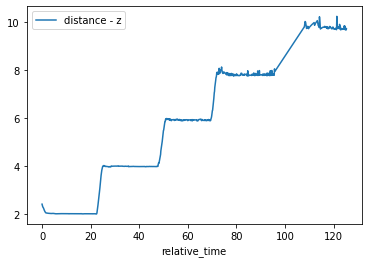

In [39]:
# initial graph
df.plot(x='relative_time', y=target)

In [40]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 1)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [41]:
# the amount of data points we are left with
len(x[peaks])

251

In [42]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='distance - z'>

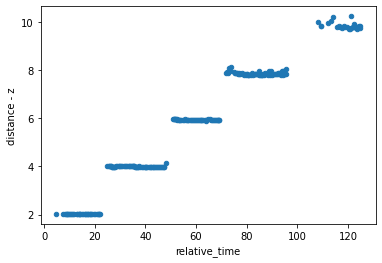

In [43]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [44]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,distance - z,true_distance
13,4.736596,2.040831,2
20,7.485761,2.032069,2
24,8.135888,2.032154,2
28,8.549247,2.031362,2
32,8.941250,2.031279,2
...,...,...,...
993,123.286459,9.738000,10
997,123.683215,9.727849,10
1001,124.321414,9.839072,10
1004,124.619870,9.845352,10


In [45]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [46]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [47]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,distance - z,true_distance,error
13,4.736596,2.040831,2,-0.040831
20,7.485761,2.032069,2,-0.032069
194,24.974355,4.002572,4,-0.002572
199,25.473922,4.034208,4,-0.034208
457,50.877203,5.962749,6,0.037251
460,51.182069,5.988813,6,0.011187
668,71.912634,7.887055,8,0.112945
670,72.114876,7.919775,8,0.080225
912,108.284683,10.026467,10,-0.026467
918,109.212483,9.823044,10,0.176956


In [48]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_distance,,,,,,,,
2,38.0,-0.029438,0.003004,-0.040831,-0.030924,-0.029602,-0.027807,-0.023385
4,66.0,-0.001240,0.020251,-0.147893,-0.003979,0.004289,0.006256,0.019563
6,50.0,0.057202,0.019387,0.011187,0.050325,0.060501,0.068222,0.105156
8,70.0,0.136781,0.072503,-0.133978,0.120218,0.161476,0.180135,0.217045
10,27.0,0.146839,0.137689,-0.241821,0.157788,0.184064,0.218061,0.272151


In [49]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

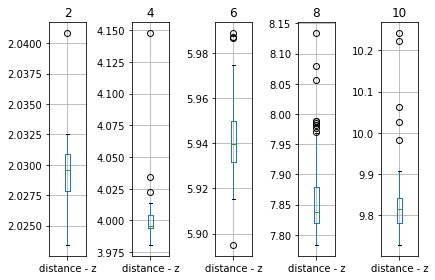

In [50]:
box_plotter(target)

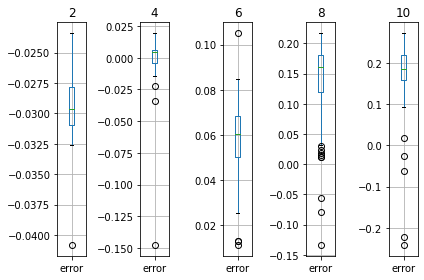

In [51]:
box_plotter('error')